In [6]:
# apple_classifier.ipynb
# Pytorch 1.8.1 cuda 11.1
# Python 3.9.2 Windows 10

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, utils, datasets, models
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
warnings.filterwarnings('ignore')
import os

In [7]:
np.random.seed(0)
torch.manual_seed(0)
train_on_gpu = torch.cuda.is_available()

def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(utils.make_grid((images[0].detach()[:nmax]), nrow=10).permute(1, 2, 0))

def show_batch(dl, nmax=50):
    for images in dl:
        show_images(images, nmax)
        break

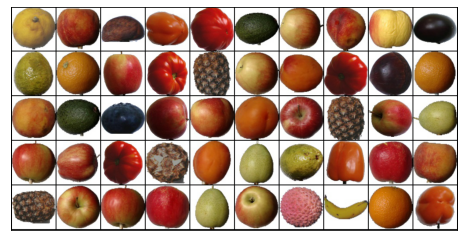

In [9]:
data_dir = 'Apple_Notapple_data'

train_data = datasets.ImageFolder(data_dir + '/Train', transform=transforms.ToTensor())
trainloader = torch.utils.data.DataLoader(train_data, batch_size=50, shuffle=True)

show_batch(trainloader)

In [10]:
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.5, 0.5, 0.5],
                                                            [0.5, 0.5, 0.5])])

valid_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.5, 0.5, 0.5],
                                                            [0.5, 0.5, 0.5])])

train_data = datasets.ImageFolder(data_dir + '/Train', transform = train_transforms)
valid_data = datasets.ImageFolder(data_dir + '/Valid', transform=  valid_transforms)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=50, shuffle=True)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=50, shuffle=True)

In [11]:
model = models.densenet121(pretrained=True)

# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False
    
model.classifier = nn.Sequential(nn.Linear(1024, 256),
                                 nn.ReLU(),
                                 nn.Dropout(0.25),
                                 nn.Linear(256, 2),
                                 nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss()

optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)
# torch.save(model, 'AppleClassifier.pth') #do not change

In [12]:
# move model to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

n_epochs = 10
valid_loss_min = np.Inf # track change in valid loss

train_losses, valid_losses = [], []

for epoch in range(n_epochs):

    # keep track of training and valid loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    
    model.train()
    for data, target in trainloader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()

        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model.forward(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    with torch.no_grad():
        accuracy = 0.0
        for data, target in validloader:
            # move tensors to GPU if CUDA is available
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model.forward(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss 
            valid_loss += loss.item()*data.size(0)
            
            # Calculate accuracy
            ps = torch.exp(output)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == target.view(*top_class.shape)
            accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
    
    # calculate average losses
    train_loss = train_loss/len(trainloader.sampler)
    valid_loss = valid_loss/len(validloader.sampler)
    
    # At completion of epoch
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    # print training/test statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \tAccuracy: {:.6f}'.format(
        epoch+1, train_loss, valid_loss, accuracy/len(validloader)))
    
    # save model if test loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
#         torch.save(model.state_dict(), 'apple_classifier.pt') optimal saved. Do not change.
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 0.257833 	Validation Loss: 0.096503 	Accuracy: 0.965172
Validation loss decreased (inf --> 0.096503).  Saving model ...
Epoch: 2 	Training Loss: 0.165040 	Validation Loss: 0.081541 	Accuracy: 0.971034
Validation loss decreased (0.096503 --> 0.081541).  Saving model ...
Epoch: 3 	Training Loss: 0.138412 	Validation Loss: 0.032355 	Accuracy: 0.991724
Validation loss decreased (0.081541 --> 0.032355).  Saving model ...
Epoch: 4 	Training Loss: 0.104927 	Validation Loss: 0.025937 	Accuracy: 0.992069
Validation loss decreased (0.032355 --> 0.025937).  Saving model ...
Epoch: 5 	Training Loss: 0.099680 	Validation Loss: 0.021449 	Accuracy: 0.993448
Validation loss decreased (0.025937 --> 0.021449).  Saving model ...
Epoch: 6 	Training Loss: 0.089422 	Validation Loss: 0.018629 	Accuracy: 0.993103
Validation loss decreased (0.021449 --> 0.018629).  Saving model ...
Epoch: 7 	Training Loss: 0.079751 	Validation Loss: 0.011968 	Accuracy: 0.995172
Validation loss decrease

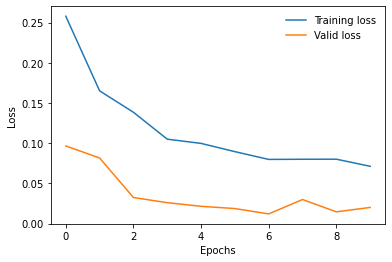

In [13]:
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Valid loss')
plt.legend(frameon=False)
# plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()